# Introduction


**Background:**
Pet homelessness is a large issue worldwide. In the US alone, it's estimated that ~6 million animals enter shelters each year; ~35% don't get adopted and ~15% end up being euthanized. PetFinder.my formed in 2008 and has become Malaysia's leading animal welfare program, aiming to centralize adoption for the thousands of stray animals across Malaysia and raise awareness of animal welfare issues across the country. The non-profit has successfully found homes for over 60,000 animals since its inception but continues to have over 20,000 that have still yet to be adopted. A key factor in adoption decisions often comes down to an animal's photo. A 2015 study conducted on dog adoption photos in the US found that photo quality had the largest positive impact on time to adoption. Other photo features that had a positive impact included direct eye contact with the cameria, the animal standing up, an outdoor background, and a non-blurry appropriately sized image. However, this research was based on a small sample of dogs only. 

PetFinder.my currently leverages an AI algorithm called the "Cutness Meter" in order to analyze photo attractiveness. However, the algorithm is in an early, experimental stage and they believe there is room for improvement. Thus, PetFinder.my is seeking the Kaggle community's help in improving their ability to predict pet popularity based on their expansive library of pet images in order to improve and save the lives of thousands of animals across Malaysia. 

**Objective:**
Our team aims to build a model that predicts the popularity of an animal based on the animal's photo. This model will support PetFinder.my's mission find homes for the thousands of animals up for adoption on their website by helping them optimize the animal images. 

**Data:**
Petfinder.my has provided photographs for thousands of the animals for adoption on their webiste. They have also provided image metadata, summarizing key photo characteristics such as whether or not the image is blurry or is an action image etc. All metadata is binary (0 for "No" and 1 for "Yes"). The target outcome variable is "Pawpularity Score," which scores each photo on a scale from 1-100 based on popularity. This score is derived based on each pet profile's page view statistics such as traffic and unique clicks. In this study "Pawpularity Score" represents interest in a pet and therefore an increased likelihood of adoption. 


*References:*

*   [ASPCA](https://www.aspca.org/)
*   [PetFinder.my](https://www.petfinder.my/)
*   [Kaggle Competition](https://https://www.kaggle.com/competitions/petfinder-pawpularity-score/overview)
*   [Speed of Dog Adoption Study](https://www.tandfonline.com/doi/abs/10.1080/10888705.2014.982796?journalCode=haaw20)






# Data Exploration

## Load and View Data

In [2]:
# Import relevant libraries 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import cv2 
import os 
import glob 
from PIL import Image

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.cluster import KMeans
from tqdm import tqdm
import shutil

In [ ]:
# Load image data
from google.colab import drive
drive.mount('/content/drive')

# Bring in original images
! mkdir petfinder_original
!unzip '/content/drive/MyDrive/W207/W207_Final_Project/petfinder-pawpularity-score' -d petfinder_original

# Bring in resized images
!mkdir petfinder
!unzip '/content/drive/MyDrive/W207/W207_Final_Project/petfinder-pawpularity-score-120exact' -d petfinder

Streaming output truncated to the last 5000 lines.
  inflating: petfinder/train/87fb09d33e25a96aa7a59dd915360f29.jpg  
  inflating: petfinder/train/624c731b8423dd9e2701de0b83aa4778.jpg  
  inflating: petfinder/train/15fd0fbbec6b316ba0b25759db21223e.jpg  
  inflating: petfinder/train/284cc235d21ddc00c52e0900d0bf32a8.jpg  
  inflating: petfinder/train/11b0c597f1eec12047b629bd76e86fa0.jpg  
  inflating: petfinder/train/a24555981c0d31f9cf0da76974882f1e.jpg  
  inflating: petfinder/train/fc21df34d426af42d3eca2e52b40957e.jpg  
  inflating: petfinder/train/f902c2b5e5532c68d403d543bd90b914.jpg  
  inflating: petfinder/train/6bc432d7253c41dcc2f7516b2b219232.jpg  
  inflating: petfinder/train/f41f62ca80e18101d5f8c932d98339e6.jpg  
  inflating: petfinder/train/e2b5bd374a6f6bc8973978a8f9fd23d8.jpg  
  inflating: petfinder/train/c699ca5e388439834605fd1a8786eaef.jpg  
  inflating: petfinder/train/47337dba4334bffdea91b8b3f1ae9ada.jpg  
  inflating: petfinder/train/c442030c2cb499fea349a86768c56db9.jpg

In [3]:
# Bring in photo metadata 

# Load training images metadata 

metadata = pd.read_csv('/content/drive/MyDrive/W207/W207_Final_Project/train.csv')

# Look at first 5 rows
metadata.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
# Observe lengths and null values in metadata
print('Number of rows in metadata: ', len(metadata))
print('Number of null values in metadata: ', len(metadata[metadata.isna().any(axis=1)]))

Number of rows in metadata:  9912
Number of null values in metadata:  0


In [5]:
# Get number of unique values per column
metadata.nunique()

Id               9912
Subject Focus       2
Eyes                2
Face                2
Near                2
Action              2
Accessory           2
Group               2
Collage             2
Human               2
Occlusion           2
Info                2
Blur                2
Pawpularity       100
dtype: int64

In [6]:
# Observe min & max by column
metadata.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
count,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000,9912.000000
mean,0.027643,0.772599,0.903955,0.861582,0.009988,0.067797,0.129338,0.049637,0.166263,0.172014,0.061239,0.070420,38.039044
std,0.163957,0.419175,0.294668,0.345356,0.099444,0.251409,0.335591,0.217204,0.372335,0.377411,0.239780,0.255866,20.591990
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


Total Number of Images:  9912


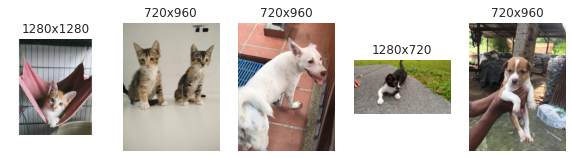

In [7]:
# Look at first 5 images in image data
img_dir = "/content/petfinder_original/train/" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
num_imgs = (len(files))
print('Total Number of Images: ', num_imgs)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = Image.open(files[i])

  width, height = image.size
 
  axs[i].imshow(image)
  axs[i].set_title(str(width) + 'x' + str(height))
  axs[i].axis('off')

plt.show()


**Initial Data Observations**

Photo Metadata


*   There are 9,912 images in the dataset and 12 summarized features for each image. 
*   Each metadata feature is binary (0 for 'No' and 1 for 'Yes'); there is no missing data.

Image Data

*   There are also 9,912 photos in the dataset.
*   Photos are colored and have varying sizes





**Metadata Feature Descriptions**

Feature  | Description
-------------------|------------------
Focus | Pet stands out against uncluttered background, not too close / far.|
Eyes | Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.|
Face | Decently clear face, facing front or near-front.|
Near | Single pet taking up significant portion of photo (roughly over 50% of photo width or height).|
Action | Pet in the middle of an action (e.g., jumping).|
Accessory | Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.|
Group | More than 1 pet in the photo.|
Collage | Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).|
Human | Human in the photo.|
Occlusion | Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.|
Info | Custom-added text or labels (i.e. pet name, description)|
Blur | Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0. |

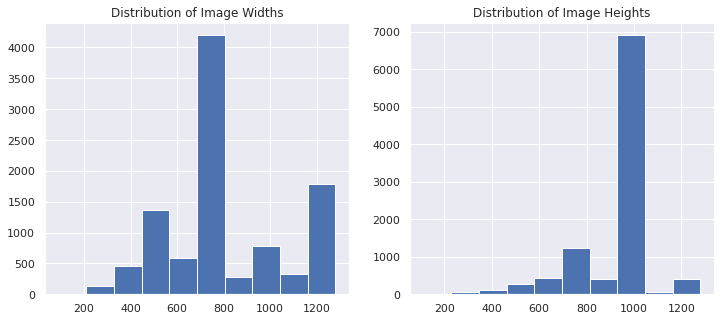



Most Common Image Width:  720
Percent of Images with Width:  36%


Most Common Image Height:  960
Percent of Images with Height:  66%


In [8]:
# Plot distribution of image widths and heights 
img_dir = "/content/petfinder_original/train/" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 
img_widths = []
img_heights = []

for i in range(num_imgs):
  image = Image.open(files[i])
  width, height = image.size
  img_widths.append(width)
  img_heights.append(height)

# Create plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs[0].hist(img_widths)
axs[0].set_title('Distribution of Image Widths')
axs[1].hist(img_heights)
axs[1].set_title('Distribution of Image Heights')

plt.show()

# Get most common width and height
most_common_width = max(set(img_widths), key=img_widths.count)
most_common_width_count = img_widths.count(most_common_width)

most_common_height = max(set(img_heights), key=img_heights.count)
most_common_height_count = img_heights.count(most_common_height)

print('\n')
print('Most Common Image Width: ', most_common_width)
print('Percent of Images with Width: ', str(round((most_common_width_count/len(img_widths)) * 100)) + '%')
print('\n')
print('Most Common Image Height: ', most_common_height)
print('Percent of Images with Height: ', str(round((most_common_height_count/len(img_heights)) * 100))+ '%')


We resize the images to 90X120 which is the same aspect ratio as the most commonly found image resolution of 720X960. 
When we attempted to resize the images in colab, we ran into memory issues on colab. So, we used a online tool called [ImageMagick](https://imagemagick.org/index.php) for resizing the images, and brought the resized images in for use in the models. 

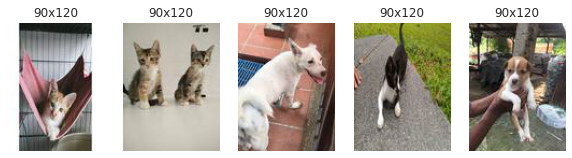

In [ ]:
# View the first 5 images in resized image data
img_dir = "/content/petfinder/train/" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):

  resized_image = load_img(files[i])
  width, height = resized_image.size

  axs[i].imshow(resized_image)
  axs[i].set_title(str(width) + 'x' + str(height))
  axs[i].axis('off')

plt.show()

# Train / Val / Test Split

In [16]:
# Train / test split

# Shuffle the order of the rows
np.random.seed(0)
pet_data = metadata.reindex(np.random.permutation(metadata.shape[0]))

# Use a ~70/20/10 train/validation/test split.
train_len = int(round(len(pet_data)*0.70, 0))
val_len = int(round(len(pet_data)*0.20, 0))

pet_train = pet_data[:train_len]
pet_val = pet_data[train_len:train_len+val_len]
pet_test = pet_data[train_len+val_len:]

# Create list of features 
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

# Create separate variables for features and labels.
pet_train_features = pet_train[features]
pet_val_features = pet_val[features]
pet_test_features = pet_test[features]

pet_train_Ids = pet_train['Id']
pet_val_Ids = pet_val['Id']
pet_test_Ids = pet_test['Id']

pet_train_labels = pet_train['Pawpularity']
pet_val_labels = pet_val['Pawpularity']
pet_test_labels = pet_test['Pawpularity']

# Confirm the data shapes are as expected.
print('train data shape:', pet_train_features.shape)
print('train labels shape:', pet_train_labels.shape)
print('validation data shape:', pet_val_features.shape)
print('validation labels shape:', pet_val_labels.shape)
print('test data shape:', pet_test_features.shape)
print('test labels shape:', pet_test_labels.shape)

train data shape: (6938, 12)
train labels shape: (6938,)
validation data shape: (1982, 12)
validation labels shape: (1982,)
test data shape: (992, 12)
test labels shape: (992,)


In [17]:
# function to build train/val/test image arrays
def buildImageList(idList, location):
  array = []
  for id in idList:
    imageName = location + str(id) + ".jpg"
    array.append(imageName)
  return array

In [18]:
def extractImageName(image):
   nameArray = image.split('/')
   string = nameArray[-1].replace('.jpg', '')
   return string

In [19]:
# Build train/val/test image lists from resized - for models

resized_images_location = "/content/petfinder/train/"
original_images_location = "/content/petfinder_original/train/"

train_images = buildImageList(pet_train_Ids.to_numpy(),resized_images_location)

val_images = buildImageList(pet_val_Ids.to_numpy(),resized_images_location)

test_images = buildImageList(pet_test_Ids.to_numpy(),resized_images_location)

# Build train/val/test images lists from original images - for feature extraction

train_images_original = buildImageList(pet_train_Ids.to_numpy(),original_images_location)

val_images_original = buildImageList(pet_val_Ids.to_numpy(),original_images_location)

test_images_original = buildImageList(pet_test_Ids.to_numpy(),original_images_location)


# Exploratory Data Analysis

### Visualize photo metadata

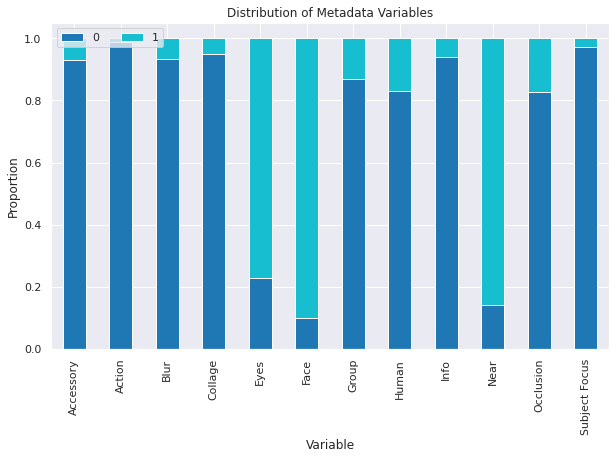

Percent of Images by Metadata Variable Value


value,0,1
variable,,
Accessory,93.0,7.0
Action,99.0,1.0
Blur,93.0,7.0
Collage,95.0,5.0
Eyes,23.0,77.0
Face,10.0,90.0
Group,87.0,13.0
Human,83.0,17.0
Info,94.0,6.0


In [20]:
# Stacked bar chart by variable
new_df = pd.melt(pet_train, id_vars=['Id'], 
                 value_vars=['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                             'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'])


cross_tab_prop = pd.crosstab(index=new_df['variable'],
                             columns=new_df['value'],
                             normalize="index")


cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(10, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Variable")
plt.ylabel("Proportion")
plt.title("Distribution of Metadata Variables")
plt.show()

print('Percent of Images by Metadata Variable Value')
cross_tab_perc = cross_tab_prop.apply(lambda x : round(x*100))
cross_tab_perc

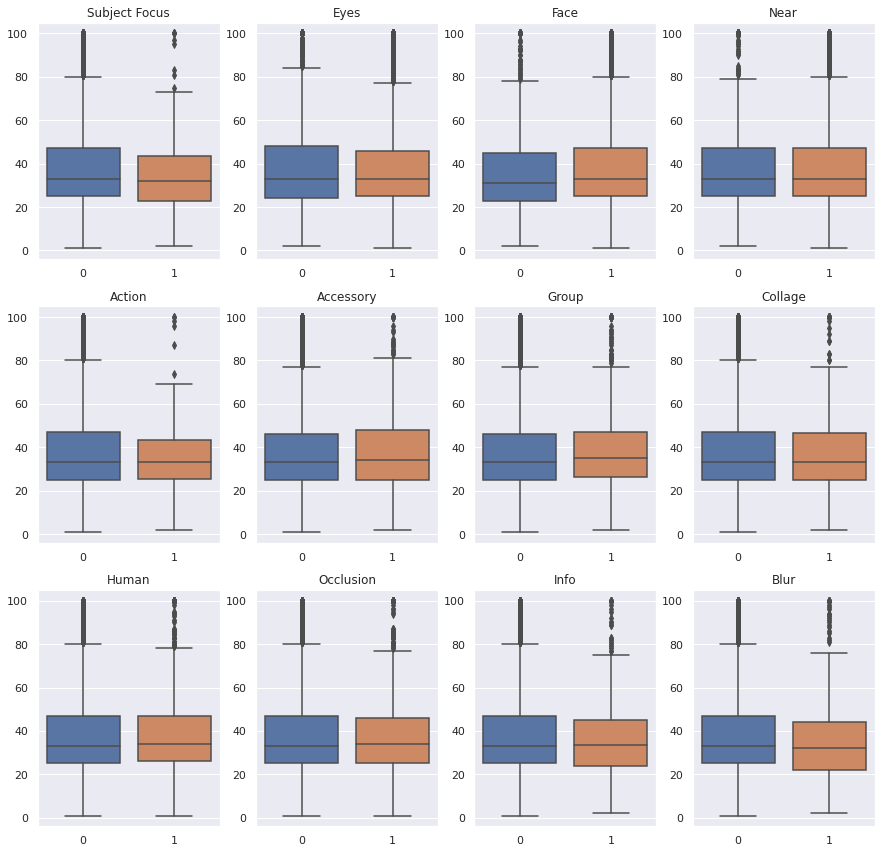

In [ ]:
# Distribution of each variable with pawpularity 
columns = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 
                               'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']

plt.figure(figsize=(15, 20))
for i in range(len(columns)-1):
  plt.subplot(4, 4, i+1)
  sns.boxplot(x=columns[i], y='Pawpularity', data = pet_train).set(xlabel=None, ylabel=None)
  plt.title(columns[i])
plt.show()


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
Subject Focus,1.000000,0.076179,0.037393,0.060635,0.013611,0.016131,-0.052651,-0.040076,-0.078312,-0.079434,-0.043622,-0.046906,-0.015954
Eyes,0.076179,1.000000,0.590746,0.136679,-0.025689,0.053667,-0.089294,0.069281,0.022109,0.012287,0.043832,-0.496318,-0.008314
Face,0.037393,0.590746,1.000000,0.148582,-0.023682,0.039575,-0.116027,0.054356,0.011360,0.003291,0.023874,-0.075603,0.019124
Near,0.060635,0.136679,0.148582,1.000000,-0.026629,0.036626,-0.329876,-0.270612,0.069373,-0.007855,-0.150080,-0.026715,-0.002161
Action,0.013611,-0.025689,-0.023682,-0.026629,1.000000,0.018527,0.002194,-0.012377,-0.004916,-0.002425,-0.021217,0.003375,0.000859
Accessory,0.016131,0.053667,0.039575,0.036626,0.018527,1.000000,-0.062014,0.073413,-0.036192,-0.031309,0.077011,-0.031417,0.009779
Group,-0.052651,-0.089294,-0.116027,-0.329876,0.002194,-0.062014,1.000000,0.117540,-0.104646,0.001225,0.054872,0.004304,0.013322
Collage,-0.040076,0.069281,0.054356,-0.270612,-0.012377,0.073413,0.117540,1.000000,0.001152,0.049090,0.484624,-0.020579,-0.001710
Human,-0.078312,0.022109,0.011360,0.069373,-0.004916,-0.036192,-0.104646,0.001152,1.000000,0.643339,0.026593,-0.011913,0.005032
Occlusion,-0.079434,0.012287,0.003291,-0.007855,-0.002425,-0.031309,0.001225,0.049090,0.643339,1.000000,0.113933,-0.004093,-0.006915


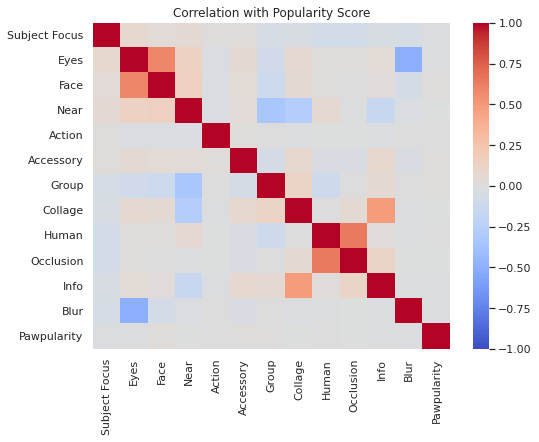

In [ ]:
# Create correlation matrix
pet_train_corr_df = pet_train[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 
                               'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']]
                               
corr_matrix = pet_train_corr_df.corr()

# Heatmap to visualize the correlation matrix
# sns.heatmap(corr_matrix, annot=False)
plt.figure(figsize=(8,6))
plt.title('Correlation with Popularity Score')
sns.heatmap(corr_matrix, vmin=-1, cmap='coolwarm', annot=False)
corr_matrix

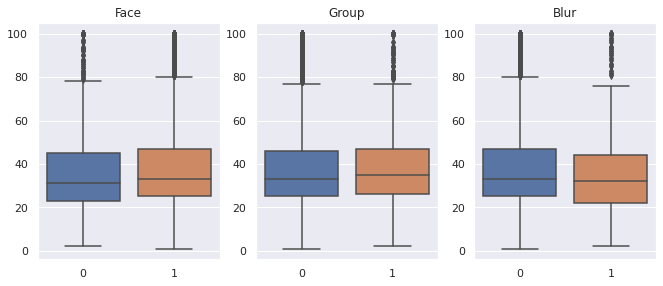

In [ ]:
# Look again at the distribution for only the variables that had strongest correlations with Popularity Score
columns = ['Face', 'Group', 'Blur', 'Pawpularity']

plt.figure(figsize=(15, 20))
for i in range(len(columns)-1):
  plt.subplot(4, 4, i+1)
  sns.boxplot(x=columns[i], y='Pawpularity', data = pet_train).set(xlabel=None, ylabel=None)
  plt.title(columns[i])
plt.show()

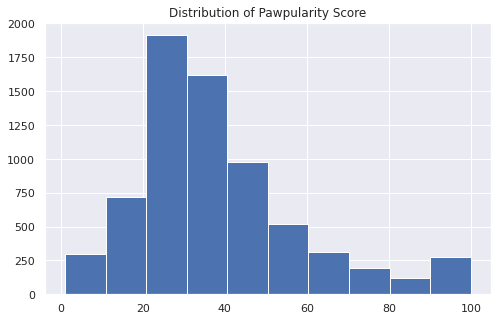

In [ ]:
# Create histogram of distribution of Pawpularity Score
plt.figure(figsize=(8, 5))
plt.hist(pet_train['Pawpularity'])
plt.title('Distribution of Pawpularity Score')
plt.show()

In [ ]:
# Assess mean and median of popularity score
pet_train['Pawpularity'].describe()

count    6938.000000
mean       38.024647
std        20.640441
min         1.000000
25%        25.000000
50%        33.000000
75%        47.000000
max       100.000000
Name: Pawpularity, dtype: float64

**Initial Observations of Metadata and Labels**

*   It appears that many of the images in the dataset are similar across the various metadata variables; this may make it challenging to predict popularity leveraging the metadata features only.
*   Some of the metadata features appear to be highly correlated with each other. For example face and eyes have a correlation of 0.59, which makes sense given that an animal's eyes facing front also likely means there is a clear view of the animal's face. Info and collage are also highly correlated (r = 0.48), suggesting that aminal images with labels such as name or description, are also more likely to be digitally retouched or enhanced. This makes sense given that both of these features are indicative of someone taking time to enhance the photo in some way. Lastly, human and occlusion are highly correlated (r = 0.64), which may mean that humans are often the object that's blocking a pet from being fully visible. 
*   It doesn't appear that any of the metadata variables have a particularly strong or obvious relationship with popularity. Face, blur and group are most highly correlated but these correlations are still low (none are above 0.1 or below -0.1). Having clear view of an animal's face and multiple animals in one image appears to be correlated with more popularity whereas a blurry image is correlated with less popularity.
*   Popularity score appears to be roughly normally distributed. 

#### Explore Highly Popular Photos 

The pawpularity score is approximately normally distributed, with a small spike in pawpularity around 100%. 

We make a subset of rows with pawpularity > 98% and check if there are any significant differences in photo metadata for the high pawpularity photos.

We don't observe major differences in features between the two groups. The highly popular photos are less blurry, appear to have more humans and lesser occlusions (underirable objects or interruptions) than the rest of the photos. 

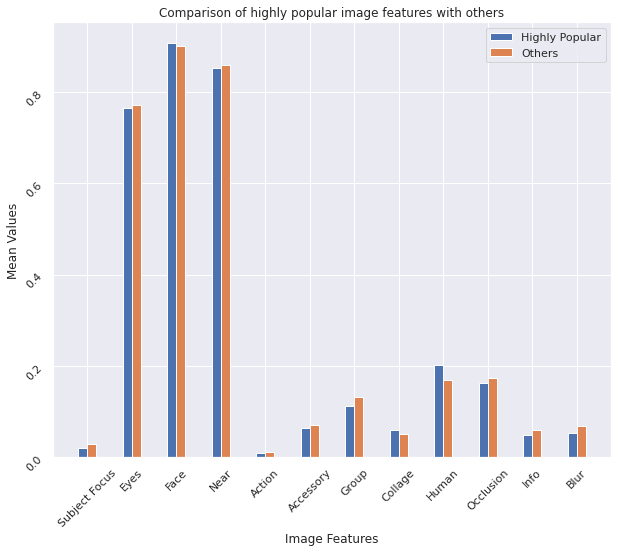

In [ ]:
# Create list of features 
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


highly_popular_features_mean = []
other_features_mean = []

for feature in features:
  x1 = pet_train[feature][pet_train['Pawpularity'] > 98].mean()
  x2 = pet_train[feature][pet_train['Pawpularity'] <= 98].mean()
  highly_popular_features_mean.append(x1)
  other_features_mean.append(x2)


X_axis = np.arange(len(features))

plt.figure(figsize=(10,8))
plt.bar(X_axis - 0.1, highly_popular_features_mean, 0.2, label = 'Highly Popular')
plt.bar(X_axis + 0.1, other_features_mean, 0.2, label = 'Others')

plt.xticks(X_axis, features)
plt.xlabel("Image Features")
plt.ylabel("Mean Values")
plt.title("Comparison of highly popular image features with others")
plt.legend()
plt.tick_params(rotation=45)
plt.show()

Number of highly popular photos:  204


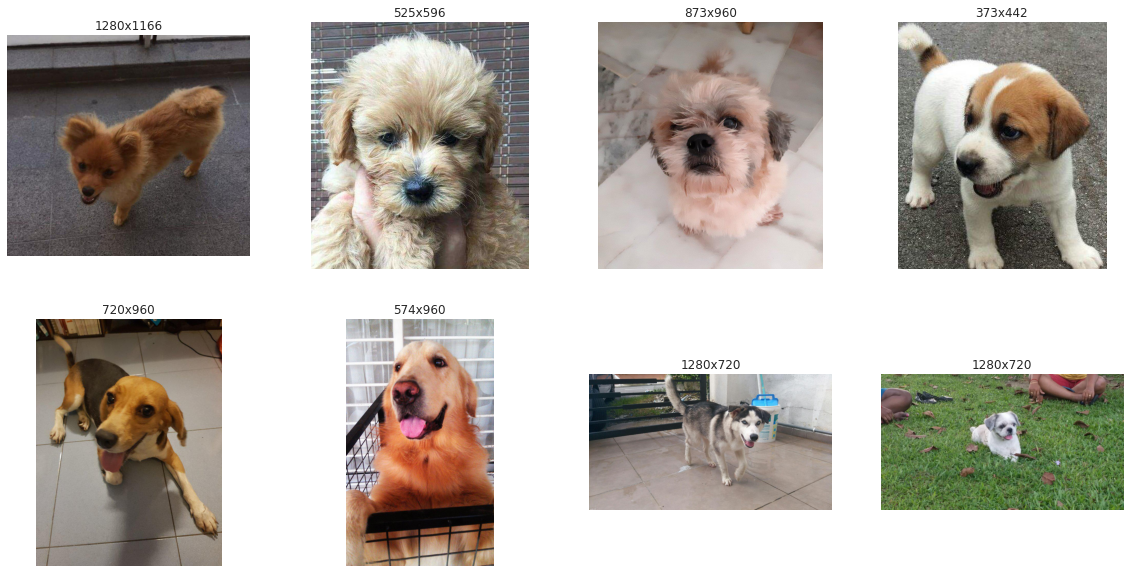

In [ ]:
# View some of the highly popular photos

highlyPopularIds = pet_train["Id"][pet_train['Pawpularity'] >= 99]
print("Number of highly popular photos: ", len(highlyPopularIds))

img_dir = "/content/petfinder_original/train/" # Enter Directory of all images  

# Build image list from the first 8 Ids
highlyPopularImageIds = []
for id in highlyPopularIds[:8]:
  image_name = img_dir + id + ".jpg"
  highlyPopularImageIds.append(image_name)

indx = 0
nrows, ncols = 2,4 #print first 8 images
fig, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        image = Image.open(highlyPopularImageIds[indx])
        
        width, height = image.size
        
        axs[i,j].imshow(image)
        axs[i,j].set_title(str(width) + 'x' + str(height))
        axs[i,j].axis('off')
        indx += 1

plt.show()

From viewing the first 8 images, we observe that all the images are dog photos. Hence, we will try to cluster the images into Dog and Cat images and explore the differences in popularity score between the two groups.

# Baseline

We will start out by building a multiple linear regression model and assessing performance on the photo metadata available. 

Linear Regression Large Sample Assumptions:


1.   **Data is independent and identically distributed (IID).** It is fair to assume the data is IID given that all photos were selected from the Petfinder website and the Kaggle competition does not specify any particular methodology for this selection that would suggest it was not random.
2.   **A unique, best linear predictor exists i.e. the covariances between features and the covariances between features and labels are finite; there is no perfect collinearity between our features.**  It is fair to assumpe a unique BLP exists given that the distribution of Pawpularity is not heavily skewed and none of our features are perfectly correlated with each other. 

We will use the RMSE to evaluate the performance of our models given that our labels are continous (popularity score 1-100).

RMSE is defined as:

$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

where $( \hat{y}_i )$ is the predicted pawpularity and $(y_i)$ is the original pawpularity for each instance $(i)$.

In [ ]:
# Create baseline model using train data
x_train = pet_train_features.to_numpy()
y_train = pet_train_labels.to_numpy()
x_train, y_train = np.array(x_train), np.array(y_train)

model = LinearRegression().fit(x_train, y_train)

# Evaluate baseline on the train data
y_train_pred = model.predict(x_train)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate baseline on the val data 
x_val = pet_val_features.to_numpy()
y_val = pet_val_labels.to_numpy()

y_val_pred = model.predict(x_val)
rms_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluate baseline on the test data 
x_test = pet_test_features.to_numpy()
y_test = pet_test_labels.to_numpy()

y_test_pred = model.predict(x_test)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of val: ", rms_val)
print("RMSE of test: ", rms_test)

37.13346364392504 [-1.86648392 -2.99903945  3.71444987  0.02221159  0.10532704  0.92919357
  1.01474993  0.07595775  0.98625882 -0.97525392 -0.83145102 -3.82671624] 0.0033413809061265676
RMSE of train:  20.604442966336897
RMSE of val:  20.584525783783626
RMSE of test:  20.3086243484471


In [ ]:
# Alternatively, use the statsmodel library to run OLS regression and get a model summary with p-values and F-statistic

import statsmodels.api as sm

# define response variable
y = pet_train_labels

# define predictor variables
x = pet_train_features

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:            Pawpularity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.935
Date:                Sun, 31 Jul 2022   Prob (F-statistic):             0.0261
Time:                        02:29:51   Log-Likelihood:                -30836.
No. Observations:                6938   AIC:                         6.170e+04
Df Residuals:                    6925   BIC:                         6.179e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            37.1335      1.037     35.803

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Running OLS regression gives us the following linear model:

$\text{Pawpularity Score} = 36.42 - 1.6*\text{Subject Focus}  - 2*\text{Eyes} + 2.8*\text{Face} + 0.8*\text{Near} + 1.4*\text{Action} + 0.95*\text{Accessory} + 1.8*\text{Group} + 1.01*\text{Collage} + 0.08*\text{Human} - 0.09*\text{Occlusion} - 0.03 *\text{Info} - 5.24*\text{Blur}$

*An example of how we can intepret the model:*

Face: Holding other factors constant, the pawpularity score will increase by 2.8 points if the image has a clear pet face facing front. 

The features **Eyes**, **Face**, **Group** and **Blur** are siginificant according to the model, with p-values less than 0.05. 

In [ ]:
# Re-run the linear regression, this time wuth just the significant features from above

features = ['Eyes', 'Face', 'Group', 'Blur']
pet_train_features = pet_train[features]
pet_val_features = pet_val[features]
pet_test_features = pet_test[features]

x_train = pet_train_features.to_numpy()
y_train = pet_train_labels.to_numpy()
x_train, y_train = np.array(x_train), np.array(y_train)

model = LinearRegression().fit(x_train, y_train)

# Evaluate baseline on the train data
y_train_pred = model.predict(x_train)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate baseline on the test data 
x_test = pet_test_features.to_numpy()
y_test = pet_test_labels.to_numpy()

y_test_pred = model.predict(x_test)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of test: ", rms_test)


37.16351100391767 [-3.05590959  3.73367     0.86696841 -3.8405228 ] 0.0026763240619874784
RMSE of train:  20.611316353240202
RMSE of test:  20.296562879534576


After the reduction in features, the RMSE doesn't move much for both train and test data. 

# Additional Models

### 1. K-nearest neighbor model with the photo metadata

Observations: The model does worse than the baseline linear regression when applied to photo metadata

In [21]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error
 
knn = KNeighborsClassifier(n_neighbors=50)
 
knn.fit(pet_train_features, pet_train_labels)
 
print("RMSE val for KNN model", sqrt(mean_squared_error(pet_val_labels,knn.predict(pet_val_features))))
print("RMSE test for KNN model", sqrt(mean_squared_error(pet_test_labels,knn.predict(pet_test_features))))

RMSE val for KNN model 24.054806241788143
RMSE test for KNN model 24.174558407415603


At this point, we bring in the pet images and try to leverage those to improve on the baseline model. 

We use the images to extract certain features that we think might affect the popularity of a pet image. The attributes that we attempt to extract are given below:

- Classify an image as a cat image or a dog image
- Extract the brightness of an image
- Extract the colorfulness of an image

In [22]:
# Function to Extract features from the images
from tensorflow.keras.preprocessing import image

def image_feature(images):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    img_name = [];
    for i in tqdm(images):
        fname=i
        img=image.load_img(fname,target_size=(224,224))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

In [23]:
# Extract train image features
train_img_features,train_img_name=image_feature(train_images_original)

100%|██████████| 6938/6938 [23:08<00:00,  4.99it/s]


In [24]:
# Creating Clusters of training dogs and cats using transfer learning (InceptionV3 trained on imagenet)
k = 2
clusters = KMeans(k, random_state = 40)
clusters.fit(train_img_features)

KMeans(n_clusters=2, random_state=40)

In [25]:
train_image_cluster = pd.DataFrame(train_img_name,columns=['image'])
train_image_cluster["clusterid"] = clusters.labels_

In [26]:
train_dogs = train_image_cluster[train_image_cluster.clusterid == 0]
train_cats = train_image_cluster[train_image_cluster.clusterid == 1]


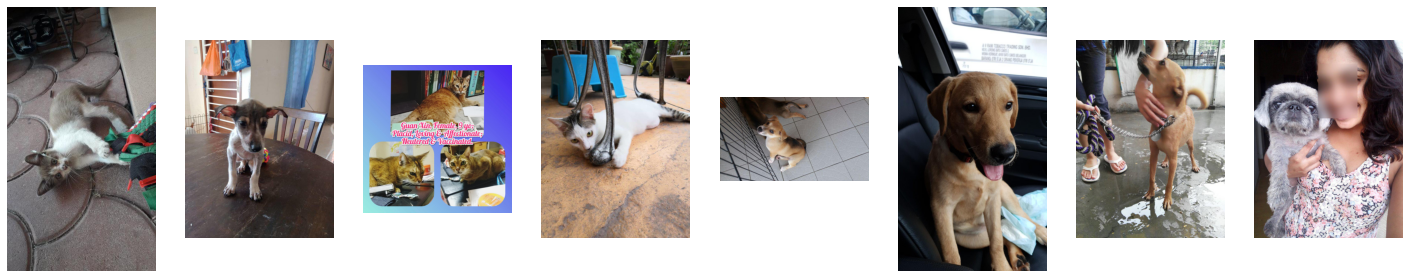

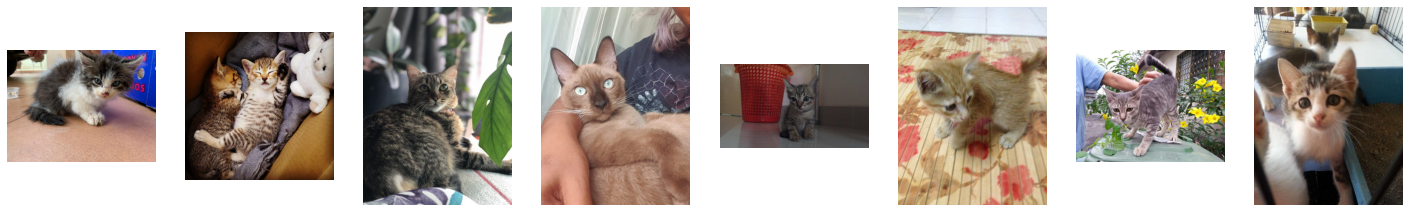

In [27]:
from PIL import Image


for imageSet in [train_dogs[:8], train_cats[:8]]:

  fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(25,15))
  counter = 0
  for index, row in imageSet.iterrows():
    image = Image.open(row['image'])
    
    axs[counter].imshow(image)
    axs[counter].axis('off')
    counter += 1
  plt.show()



In [28]:
train_dogImageNames = []
for index, row in train_dogs.iterrows():
  string = extractImageName(row['image'])
  train_dogImageNames.append(string)
  
print(len(train_dogImageNames))


train_catImageNames = []
for index, row in train_cats.iterrows():
  string = extractImageName(row['image'])
  train_catImageNames.append(string)
  
print(len(train_catImageNames))

3843
3095


In [29]:
# Add a column to the training metadata identifying a pet as a dog or a cat
pet_train['isDog'] = np.where(pet_train['Id'].isin(train_dogImageNames), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# Compare pawpularity of cats vs dogs
dog_pawpularity = pet_train[pet_train['Id'].isin(train_dogImageNames)]['Pawpularity'].mean()
print("Average dog popularity in training data:", dog_pawpularity)

cat_pawpularity = pet_train[pet_train['Id'].isin(train_catImageNames)]['Pawpularity'].mean()
print("Average cat popularity in training data:", cat_pawpularity)

Average dog popularity in training data: 40.80874316939891
Average cat popularity in training data: 34.56768982229402


In [31]:
# Extract validation image features
from tensorflow.keras.preprocessing import image
val_img_features,val_img_name=image_feature(val_images_original)

100%|██████████| 1982/1982 [12:47<00:00,  2.58it/s]


In [32]:
# Creating Clusters of validation dogs and cats using transfer learning (InceptionV3 trained on imagenet)
k = 2
clusters = KMeans(k, random_state = 40)
clusters.fit(val_img_features)

KMeans(n_clusters=2, random_state=40)

In [33]:
val_image_cluster = pd.DataFrame(val_img_name,columns=['image'])
val_image_cluster["clusterid"] = clusters.labels_

In [34]:
val_dogs = val_image_cluster[val_image_cluster.clusterid == 0]
val_cats = val_image_cluster[val_image_cluster.clusterid == 1]
print(len(val_dogs))
print(len(val_cats))

1061
921


In [35]:
val_dogImageNames = []
for index, row in val_dogs.iterrows():
  string = extractImageName(row['image'])
  val_dogImageNames.append(string)
  
print(len(val_dogImageNames))


val_catImageNames = []
for index, row in val_cats.iterrows():
  string = extractImageName(row['image'])
  val_catImageNames.append(string)
  
print(len(val_catImageNames))

1061
921


In [36]:
# Add a column to the test metadata identifying a pet as a dog or a cat
pet_val['isDog'] = np.where(pet_val['Id'].isin(val_dogImageNames), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
# Extract test image features
from tensorflow.keras.preprocessing import image
test_img_features,test_img_name=image_feature(test_images_original)

100%|██████████| 992/992 [03:35<00:00,  4.61it/s]


In [38]:
# Creating Clusters of test dogs and cats using transfer learning (InceptionV3 trained on imagenet)
k = 2
clusters = KMeans(k, random_state = 40)
clusters.fit(test_img_features)

KMeans(n_clusters=2, random_state=40)

In [39]:
test_image_cluster = pd.DataFrame(test_img_name,columns=['image'])
test_image_cluster["clusterid"] = clusters.labels_

In [40]:
test_dogs = test_image_cluster[test_image_cluster.clusterid == 1]
test_cats = test_image_cluster[test_image_cluster.clusterid == 0]
print(len(test_dogs))
print(len(test_cats))

550
442


In [41]:
test_dogImageNames = []
for index, row in test_dogs.iterrows():
  string = extractImageName(row['image'])
  test_dogImageNames.append(string)
  
print(len(test_dogImageNames))


test_catImageNames = []
for index, row in test_cats.iterrows():
  string = extractImageName(row['image'])
  test_catImageNames.append(string)
  
print(len(test_catImageNames))

550
442


In [42]:
# Add a column to the test metadata identifying a pet as a dog or a cat
pet_test['isDog'] = np.where(pet_test['Id'].isin(test_dogImageNames), 1, 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 2. Linear Regression with isDog feature added to photo metadata

In [43]:
# Create list of features 
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'isDog']

# Recompute features with isDog feature added. The labels stay the same
pet_train_features = pet_train[features]
pet_val_features = pet_val[features]
pet_test_features = pet_test[features]


In [44]:
x_train = pet_train_features.to_numpy()
y_train = pet_train_labels.to_numpy()
x_train, y_train = np.array(x_train), np.array(y_train)

model = LinearRegression().fit(x_train, y_train)

# Evaluate baseline on the train data
y_train_pred = model.predict(x_train)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate baseline on the val data 
x_val = pet_val_features.to_numpy()
y_val = pet_val_labels.to_numpy()

y_val_pred = model.predict(x_val)
rms_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluate baseline on the test data 
x_test = pet_test_features.to_numpy()
y_test = pet_test_labels.to_numpy()

y_test_pred = model.predict(x_test)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of val: ", rms_val)
print("RMSE of test: ", rms_test)


31.803915898962934 [-6.59576742e-01 -1.86451636e+00  3.85109307e+00  1.02057118e+00
 -1.44702656e-03  6.22657672e-01  1.03050983e+00 -3.08212402e-01
  6.07126333e-01 -1.38414685e+00 -1.06380097e+00 -2.70760696e+00
  6.41128473e+00] 0.02594458385286247
RMSE of train:  20.36945913086575
RMSE of val:  20.323996985157052
RMSE of test:  20.132373185331844


In [45]:
# Use the statsmodel library to run OLS regression and get a model summary with p-values and F-statistic

import statsmodels.api as sm

# define response variable
y = pet_train_labels

# define predictor variables
x = pet_train_features

# add constant to predictor variables
x = sm.add_constant(x)

# fit linear regression model
model = sm.OLS(y, x).fit()

# view model summary
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:            Pawpularity   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     14.19
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           6.16e-32
Time:                        00:34:27   Log-Likelihood:                -30756.
No. Observations:                6938   AIC:                         6.154e+04
Df Residuals:                    6924   BIC:                         6.164e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            31.8039      1.108     28.697

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The RMSE appears to have reduced for both train and test sets when compared with the baseline. Hence, this model is performing sligthly better than the baseline at predicting pet pawpularity score. 

### 3.Linear Regression with more features extracted from image data




We will attempt to extract other photo attributes that mgwe think might affect the attractiveness of a photo in general, such as how colorful the image is, and its brigthness. 

In [ ]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [ ]:
def brightness( im_file ):
   im = Image.open(im_file)
   stat = ImageStat.Stat(im)
   r,g,b = stat.rms
   return math.sqrt(0.241*(r**2) + 0.691*(g**2) + 0.068*(b**2))

In [ ]:
from PIL import ImageStat
import math

colorfulness = {}
image_brightness = {}

img_dir = "/content/petfinder_original/train/" # Enter Directory of all images  
data_path = os.path.join(img_dir,'*g') 
files = glob.glob(data_path) 

for file in files:
    image = cv2.imread(file)
    C = image_colorfulness(image)
    B = brightness(file)
    imageName = extractImageName(file)
    image_brightness[imageName] = B
    colorfulness[imageName] = C

In [ ]:
colorfulness_df = pd.DataFrame(colorfulness.items(), columns=['Id', 'Colorfulness'])

brightness_df = pd.DataFrame(image_brightness.items(), columns=['Id', 'Brightness'])


In [ ]:
merged_train_df =  pd.merge(colorfulness_df, pet_train, on='Id')
merged_train_df =  pd.merge(brightness_df, merged_train_df, on='Id')

merged_test_df = pd.merge(colorfulness_df, pet_test, on='Id')
merged_test_df = pd.merge(brightness_df, merged_test_df, on='Id')


In [ ]:
# Download the new datasets with the features added to avoid recomputing them
from google.colab import files

merged_train_df.to_csv('train_extracted_features.csv')
files.download('train_extracted_features.csv')

merged_test_df.to_csv('test_extracted_features.csv')
files.download('test_extracted_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the training data csv with extra features added 

url = 'https://raw.githubusercontent.com/sunaynaj-mids/PawpularityPredictor/main/train_extracted_features.csv'
pet_train_extra_features = pd.read_csv(url)

pet_train_extra_features.head(10)

,Unnamed: 0,Id,Brightness,Colorfulness,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,isDog
0,0,04401eb40ba1e016aaecb5e0958ff1ab,171.091876,24.761134,0,1,1,0,0,0,0,1,0,0,0,0,35,0
1,1,3345633591287ee7c6f6f46d7c2e1a2e,176.207367,15.875401,0,1,1,1,0,0,1,0,0,0,0,0,27,0
2,2,cfac085036f560dacc6e7af69ecedba8,156.744763,41.088799,0,1,1,1,0,0,0,0,0,0,0,0,17,1
3,3,06453783081e3e7db3b8ddd73ff78d58,134.841557,51.301853,0,1,1,1,0,0,0,0,1,0,0,0,32,1
4,4,c780797f5ffbe2464ded97aeefc6db03,159.782553,20.178111,0,1,1,1,0,0,0,0,0,0,0,0,25,0
5,5,cf49bd2b6eb803d57d4c1d408899083d,144.104479,33.894089,0,1,1,1,0,0,0,0,0,0,0,0,37,1
6,6,cca6f558ef342ba6f1c3a8ec36aa77f4,99.106854,31.820012,0,1,1,1,0,0,0,0,0,0,0,0,44,0
7,7,108519f539e734434cd6819c46f297ff,154.444684,18.946303,0,1,1,1,0,0,0,0,0,0,0,0,84,1
8,8,9beaff8dd8b17dcb7638f689a638a2d1,151.242022,46.390795,0,1,1,1,0,0,0,0,0,1,1,0,34,0
9,9,a5ff4923e393fa08e67da31c7eb4edd5,215.868533,14.217202,0,1,1,1,0,0,0,0,0,0,0,0,36,0


In [ ]:
# Recompute features with the additional features added 
features = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'isDog', 'Brightness', 'Colorfulness']

# Create separate variables for features and labels.
pet_train_features = merged_train_df[features]
pet_test_features = merged_test_df[features]

In [ ]:
x_train = pet_train_features.to_numpy()
y_train = pet_train_labels.to_numpy()
x_train, y_train = np.array(x_train), np.array(y_train)

model = LinearRegression().fit(x_train, y_train)

# Evaluate baseline on the train data
y_train_pred = model.predict(x_train)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate baseline on the test data 
x_test = pet_test_features.to_numpy()
y_test = pet_test_labels.to_numpy()

y_test_pred = model.predict(x_test)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of test: ", rms_test)

37.55414814351431 [-2.17336254  0.56313237  0.02623327  0.47024929 -1.26266989 -0.73094606
  0.92833437  0.36850242  0.40546738 -0.12120821  0.1004356   0.74368985
 -0.19513563 -0.00580166  0.01361982] 0.001040599533652986
RMSE of train:  20.628211882735066
RMSE of test:  20.287637821220578


The addition of brightness and colofulness does not appear to improve the RMSE of train and test data. 

### 4.Linear Regression leveraging image data directly

For running the linear regression with image data, we leverage the resized images.  

In [ ]:
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

train_image = []
for img in tqdm(train_images):
    img = image.load_img(img)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_imgs = np.array(train_image)

val_image = []
for img in tqdm(val_images):
    img = image.load_img(img)
    img = image.img_to_array(img)
    img = img/255
    val_image.append(img)
val_imgs = np.array(val_image)

test_image = []
for img in tqdm(test_images):
    img = image.load_img(img)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test_imgs = np.array(test_image)

print('Shape of Traim Images: ', train_imgs.shape)
print('Shape of Val Images: ', val_imgs.shape)
print('Shape of Test Images: ', test_imgs.shape)

100%|██████████| 992/992 [00:01<00:00, 844.39it/s]


Shape of Traim Images:  (6938, 120, 90, 3)
Shape of Val Images:  (1982, 120, 90, 3)
Shape of Test Images:  (992, 120, 90, 3)


In [ ]:
# Flatten image data
x_train_imgs = []
x_val_imgs = []
x_test_imgs = []

for img in train_imgs:
  x_train_imgs.append(img.flatten())

x_train_imgs = np.array(x_train_imgs)

for img in val_imgs:
  x_val_imgs.append(img.flatten())

x_val_imgs = np.array(x_val_imgs)

for img in test_imgs:
  x_test_imgs.append(img.flatten())

x_test_imgs = np.array(x_test_imgs)

# Convert labels to numpy array
y_train = pet_train_labels.to_numpy()
y_val = pet_val_labels.to_numpy()
y_test = pet_test_labels.to_numpy()

# Print shapes
print('X Train Shape: ', x_train_imgs.shape)
print('Y Train Shape: ', y_train.shape)
print('X Val Shape: ', x_val_imgs.shape)
print('Y Val Shape: ', y_val.shape)
print('X Test Shape: ', x_test_imgs.shape)
print('Y Test Shape: ', y_test.shape)


X Train Shape:  (6938, 32400)
Y Train Shape:  (6938,)
X Val Shape:  (1982, 32400)
Y Val Shape:  (1982,)
X Test Shape:  (992, 32400)
Y Test Shape:  (992,)


In [ ]:
# Build model
model = LinearRegression().fit(x_train_imgs, y_train)

# Evaluate on the train data
y_train_pred = model.predict(x_train_imgs)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate on the validation data 
y_val_pred = model.predict(x_val_imgs)
rms_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluate on the test data 
y_test_pred = model.predict(x_test_imgs)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train_imgs, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of val: ", rms_val)
print("RMSE of test: ", rms_test)

35.11838 [-1.2699163  2.337901   2.2643871 ... -3.1486464 -0.5412015 -2.6557112] 0.9999919883863431
RMSE of train:  0.05841813172894048
RMSE of val:  43.26860837335278
RMSE of test:  44.87460472405146


Linear regression model appears to have overfit. We will apply regularization to address to this. 

In [ ]:
from sklearn.linear_model import Lasso

# Build model
model = Lasso().fit(x_train_imgs, y_train)

# Evaluate on the train data
y_train_pred = model.predict(x_train_imgs)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate on the validation data 
y_val_pred = model.predict(x_val_imgs)
rms_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluate on the test data 
y_test_pred = model.predict(x_test_imgs)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train_imgs, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of val: ", rms_val)
print("RMSE of test: ", rms_test)

38.024647 [0. 0. 0. ... 0. 0. 0.] 0.0
RMSE of train:  20.638953120290118
RMSE of val:  20.575708856556226
RMSE of test:  20.283028759261143


### 4. CNN Using Image Data

### Image augmentation for CNN




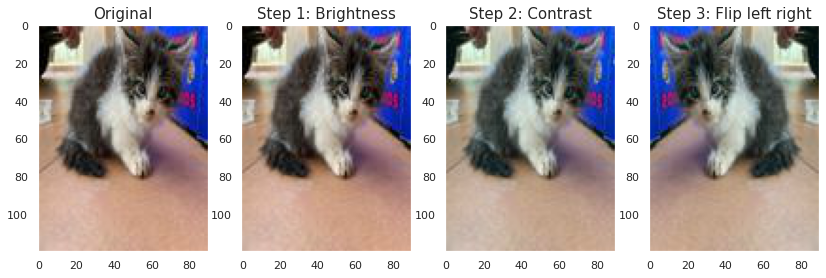

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = train_imgs[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15)
ax.grid(None)

# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 1: Brightness', size=15)
ax.grid(None)


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 2: Contrast', size=15)
ax.grid(None)


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 3: Flip left right', size=15)
ax.grid(None)

In [69]:
CONTRAST_FACTOR = 3
DELTA = 0.3

aug_train_imgs = []

for img in tqdm(train_imgs):
  # adjust brightness
  aug_img = tf.image.adjust_brightness(img, DELTA)

  # adjust contrast 
  aug_img = tf.image.adjust_contrast(aug_img, CONTRAST_FACTOR)

  # flip left right
  aug_img = tf.image.flip_left_right(aug_img)

  aug_train_imgs.append(aug_img)

aug_train_imgs = np.array(aug_train_imgs)

print(aug_train_imgs.shape)

100%|██████████| 6938/6938 [00:06<00:00, 1079.50it/s]


(6938, 120, 90, 3)


**Build Initial CNN**

For our initial model construction, we will have 2 convolutional layers followed by two max-pooling layers. 


*   The model receives input images of size 120 x 90 x 3 (there are 3 color channels)
*   The input data goes through two convolutional layers tha thave kernels of size 5 x 5 and strides of 1
*   Each convolutional layer is followed by a max-pooling layer that has a pool size of 2
*   The last layer is a fully connected layer with a linear activation 
*   We will use an Adam optimizer to avoid the exploding gradient problem. We will use batch sizes of 128 to ensure stability of the optimization. We will start with 5 epochs. 

In [70]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 120, 90, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 95,937
Trainable params: 95,937
Non-trai

In [71]:
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

In [72]:
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(aug_train_imgs, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

Epoch 1/5
55/55 [==============================] - 228s 4s/step - loss: 5555.8745 - root_mean_squared_error: 74.5377 - val_loss: 1828.5779 - val_root_mean_squared_error: 42.7619
Epoch 2/5
55/55 [==============================] - 218s 4s/step - loss: 1360.2406 - root_mean_squared_error: 36.8814 - val_loss: 1012.1910 - val_root_mean_squared_error: 31.8149
Epoch 3/5
55/55 [==============================] - 217s 4s/step - loss: 544.8738 - root_mean_squared_error: 23.3425 - val_loss: 937.6333 - val_root_mean_squared_error: 30.6208
Epoch 4/5
55/55 [==============================] - 214s 4s/step - loss: 501.0402 - root_mean_squared_error: 22.3839 - val_loss: 995.1263 - val_root_mean_squared_error: 31.5456
Epoch 5/5
55/55 [==============================] - 216s 4s/step - loss: 481.6649 - root_mean_squared_error: 21.9469 - val_loss: 897.2164 - val_root_mean_squared_error: 29.9536


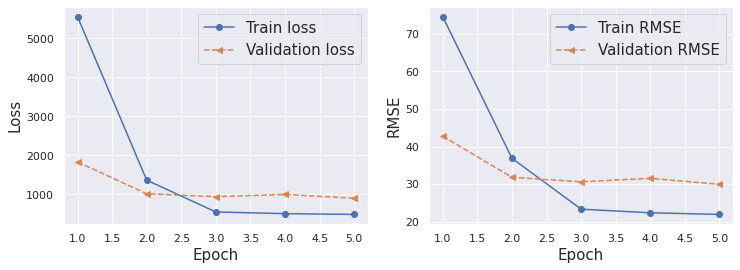

In [73]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['root_mean_squared_error'], '-o', label='Train RMSE')
ax.plot(x_arr, hist['val_root_mean_squared_error'], '--<', label='Validation RMSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('RMSE', size=15)
plt.show()

**Initial CNN Observations**

*   The RMSE appears slightly higher than our linear regression models. 
*   Train loss drops after the first epoch and then remains somewhat steady; it does not seem that adding additional epochs will meaningfully improve model performance.
*   Train and validation RMSE do not have much noise suggesting that we should keep the batch size at 128. 
*   Tuning kernel size, strides, pooling size, learning rate and augmenting the images may improve model performance. 



In [ ]:
# Adjust kernel size to (3, 3)
model_1 = tf.keras.Sequential()

# add first convolution layer to the model
model_1.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_1.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_1.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_1.add(tf.keras.layers.Flatten()) 
model_1.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_1.build(input_shape=(None, 120, 90, 3))
model_1.summary()

model_1.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_1.fit(aug_train_imgs, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 61,633
Trainable params: 61,633
Non-trai

In [ ]:
# Adjust strides to (2, 2)
model_2 = tf.keras.Sequential()

# add first convolution layer to the model
model_2.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_2.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_2.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_2.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_2.add(tf.keras.layers.Flatten()) 
model_2.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_2.build(input_shape=(None, 120, 90, 3))
model_2.summary()

model_2.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_2.fit(aug_train_imgs, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 60, 45, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 30, 22, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 15, 11, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 5, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 2240)              0         
                                                                 
 fc_2 (Dense)                (None, 1)                 2241      
                                                                 
Total params: 55,937
Trainable params: 55,937
Non-trai

In [ ]:
# Adjust pool size to (3, 3)
model_3 = tf.keras.Sequential()

# add first convolution layer to the model
model_3.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_3.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    name='pool_1'))


# add second convolutional layer
model_3.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_3.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), name='pool_2')
)


# add the last fully connected layer
model_3.add(tf.keras.layers.Flatten()) 
model_3.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_3.build(input_shape=(None, 120, 90, 3))
model_3.summary()

model_3.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_3.fit(aug_train_imgs, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 40, 30, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 40, 30, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 13, 10, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 8320)              0         
                                                                 
 fc_2 (Dense)                (None, 1)                 8321      
                                                                 
Total params: 62,017
Trainable params: 62,017
Non-trai

In [ ]:
# Adjust learning rate to 0.001
model_4 = tf.keras.Sequential()

# add first convolution layer to the model
model_4.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_4.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_4.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_4.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_4.add(tf.keras.layers.Flatten()) 
model_4.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_4.build(input_shape=(None, 120, 90, 3))
model_4.summary()

model_4.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_4.fit(aug_train_imgs, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 95,937
Trainable params: 95,937
Non-trai

In [ ]:
# Adjust brightness to 0.1
CONTRAST_FACTOR = 3
DELTA = 0.1

aug_train_imgs_m5 = []

for img in tqdm(train_imgs):
  # adjust brightness
  aug_img = tf.image.adjust_brightness(img, DELTA)

  # adjust contrast 
  aug_img = tf.image.adjust_contrast(aug_img, CONTRAST_FACTOR)

  # flip left right
  aug_img = tf.image.flip_left_right(aug_img)

  aug_train_imgs_m5.append(aug_img)

aug_train_imgs_m5 = np.array(aug_train_imgs_m5)


model_5 = tf.keras.Sequential()

# add first convolution layer to the model
model_5.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_5.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_5.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_5.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_5.add(tf.keras.layers.Flatten()) 
model_5.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_5.build(input_shape=(None, 120, 90, 3))
model_5.summary()

model_5.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_5.fit(aug_train_imgs_m5, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

100%|██████████| 6938/6938 [00:10<00:00, 677.22it/s] 


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_10 (Flatten)        (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 95,937
Trainable params: 95,937
Non-tra

In [ ]:
# Adjust contrast to 2
CONTRAST_FACTOR = 2
DELTA = 0.3

aug_train_imgs_m6 = []

for img in tqdm(train_imgs):
  # adjust brightness
  aug_img = tf.image.adjust_brightness(img, DELTA)

  # adjust contrast 
  aug_img = tf.image.adjust_contrast(aug_img, CONTRAST_FACTOR)

  # flip left right
  aug_img = tf.image.flip_left_right(aug_img)

  aug_train_imgs_m6.append(aug_img)

aug_train_imgs_m6 = np.array(aug_train_imgs_m6)


model_6 = tf.keras.Sequential()

# add first convolution layer to the model
model_6.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_6.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_6.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_6.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_6.add(tf.keras.layers.Flatten()) 
model_6.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_6.build(input_shape=(None, 120, 90, 3))
model_6.summary()

model_6.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_6.fit(aug_train_imgs_m6, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

100%|██████████| 6938/6938 [01:04<00:00, 106.80it/s] 


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_11 (Flatten)        (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 95,937
Trainable params: 95,937
Non-tra

In [ ]:
# Do not flip images
CONTRAST_FACTOR = 3
DELTA = 0.3

aug_train_imgs_m7 = []

for img in tqdm(train_imgs):
  # adjust brightness
  aug_img = tf.image.adjust_brightness(img, DELTA)

  # adjust contrast 
  aug_img = tf.image.adjust_contrast(aug_img, CONTRAST_FACTOR)

  # flip left right
  #aug_img = tf.image.flip_left_right(aug_img)

  aug_train_imgs_m7.append(aug_img)

aug_train_imgs_m7 = np.array(aug_train_imgs_m7)


model_7 = tf.keras.Sequential()

# add first convolution layer to the model
model_7.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_7.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_7.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_7.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add the last fully connected layer
model_7.add(tf.keras.layers.Flatten()) 
model_7.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_7.build(input_shape=(None, 120, 90, 3))
model_7.summary()

model_7.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_7.fit(aug_train_imgs_m7, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

100%|██████████| 6938/6938 [00:05<00:00, 1160.93it/s]


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 120, 90, 32)       2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 60, 45, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 60, 45, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 30, 22, 64)        0         
                                                                 
 flatten_12 (Flatten)        (None, 42240)             0         
                                                                 
 fc_2 (Dense)                (None, 1)                 42241     
                                                                 
Total params: 95,937
Trainable params: 95,937
Non-tra

In [ ]:
# Do not flip images
CONTRAST_FACTOR = 2
DELTA = 0.1

aug_train_imgs_m8 = []

for img in tqdm(train_imgs):
  # adjust brightness
  aug_img = tf.image.adjust_brightness(img, DELTA)

  # adjust contrast 
  aug_img = tf.image.adjust_contrast(aug_img, CONTRAST_FACTOR)

  # flip left right
  #aug_img = tf.image.flip_left_right(aug_img)

  aug_train_imgs_m8.append(aug_img)

aug_train_imgs_m8 = np.array(aug_train_imgs_m8)


model_8 = tf.keras.Sequential()

# add first convolution layer to the model
model_8.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_8.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3),
    name='pool_1'))


# add second convolutional layer
model_8.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(2, 2),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_8.add(tf.keras.layers.MaxPool2D(
    pool_size=(3, 3), name='pool_2')
)


# add the last fully connected layer
model_8.add(tf.keras.layers.Flatten()) 
model_8.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='linear'))


# build model and print summary
tf.random.set_seed(1)
model_8.build(input_shape=(None, 120, 90, 3))
model_8.summary()

model_8.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=tf.keras.metrics.RootMeanSquaredError())

tf.random.set_seed(1234)
np.random.seed(1234)
history = model_8.fit(aug_train_imgs_m8, pet_train_labels.to_numpy(),
                    epochs=5, 
                    batch_size=128,
                    validation_data=(val_imgs, pet_val_labels.to_numpy()))

100%|██████████| 6938/6938 [00:03<00:00, 1737.45it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 60, 45, 32)        2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 20, 15, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 10, 8, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 3, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 fc_2 (Dense)                (None, 1)                 385       
                                                                 
Total params: 54,081
Trainable params: 54,081
Non-traina

| Training RMSE | Validation RMSE |  kernel size |  strides | pool size  |  learning rate | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 21.9469              | 29.9536                | 5,5          | 1,1      | 2,2        | 0.01          | 0.3                | 3                | yes            |
| 41.2079               | 41.1385                 | <font color="red">3,3</font>     | 1,1      | 2,2        | 0.01          | 0.3                | 3                | yes            |
| 21.2523               | 26.6561                 | 5,5          | <font color="red">2,2</font>  | 2,2        | 0.01          | 0.3                | 3                | yes            |
| 21.1211               | 25.8123                 | 5,5          | 1,1      | <font color="red">3,3</font>   | 0.01          | 0.3                | 3                | yes            |
| 21.0283               | 25.1982                 | 5,5          | 1,1      | 2,2        | <font color="red">0.001</font>       | 0.3                | 3                | yes            |
| 22.5083               | 24.3354                 | 5,5          | 1,1      | 2,2        | 0.01          | <font color="red">0.1</font>                | 3                | yes            |
| 21.1837               | 23.7669                 | 5,5          | 1,1      | 2,2        | 0.01          | 0.3            | <font color="red">2</font>                | yes            |
| 21.5223               | 26.5409                 | 5,5          | 1,1      | 2,2        | 0.01          | 0.3                | 3            | <font color="red">no</font>            |
| 20.9944               | 23.2261                 | 5,5          | <font color="red">2,2</font>      | <font color="red">3,3</font>        | <font color="red">0.001</font>          | <font color="red">0.1</font>                | <font color="red">2</font>                | <font color="red">no</font>         |

Our final model, which adjusts strides, pool size, learning rate, and image augmentation performs the best of the CNN models. We will run our test data on the model with these specifications.

In [ ]:
model_8.evaluate(test_imgs, y_test)

31/31 [==============================] - 2s 50ms/step - loss: 520.2474 - root_mean_squared_error: 22.8089


[520.2474365234375, 22.80893325805664]

# Final Model Selection, Analysis of Errors and Key Takeaways

| Model | Train RMSE |  Validation RMSE |  Test RMSE |
|:-:                |:-:           |:-:             |:-:         |
| Baseline              | 20.6                | 20.58          | 20.31      | yes            |
| Baseline + engineered features               | 20.37                 | 20.32     | 20.13      |
| Linear regression on image data               | 20.64                 | 20.58          | 20.28  |
| CNN on image data               | 20.99                 | 23.23          | 22.81      |


The baseline model with the engineered features from the images performed the best. We will now explore the predictions for that model and see whether we can learn anything from the predictions with large residuals.



In [46]:
# Rerun linear regression with metadata and engineered features
x_train = pet_train_features.to_numpy()
y_train = pet_train_labels.to_numpy()
x_train, y_train = np.array(x_train), np.array(y_train)

model = LinearRegression().fit(x_train, y_train)

# Evaluate baseline on the train data
y_train_pred = model.predict(x_train)
rms_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Evaluate baseline on the val data 
x_val = pet_val_features.to_numpy()
y_val = pet_val_labels.to_numpy()

y_val_pred = model.predict(x_val)
rms_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Evaluate baseline on the test data 
x_test = pet_test_features.to_numpy()
y_test = pet_test_labels.to_numpy()

y_test_pred = model.predict(x_test)
rms_test = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R-squared
r_sq = model.score(x_train, y_train)

# Get intercept & coefficients
intercept = model.intercept_
coefficients = model.coef_

# Display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, r_sq)

# Compute Root Mean Squared Error of train and test data
print("RMSE of train: ", rms_train)
print("RMSE of val: ", rms_val)
print("RMSE of test: ", rms_test)

31.803915898962934 [-6.59576742e-01 -1.86451636e+00  3.85109307e+00  1.02057118e+00
 -1.44702656e-03  6.22657672e-01  1.03050983e+00 -3.08212402e-01
  6.07126333e-01 -1.38414685e+00 -1.06380097e+00 -2.70760696e+00
  6.41128473e+00] 0.02594458385286247
RMSE of train:  20.36945913086575
RMSE of val:  20.323996985157052
RMSE of test:  20.132373185331844


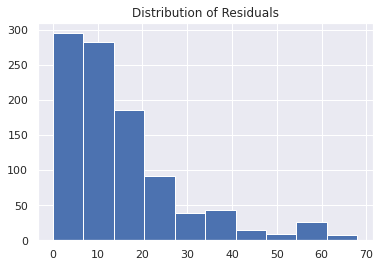

,0
count,992.000000
mean,15.007735
std,13.426170
min,0.001517
25%,5.759987
50%,11.222349
75%,19.590363
max,67.952533


In [53]:
# Calculate residuals
residuals = abs(y_test - y_test_pred)

# Plot histogram of residuals
plt.hist(residuals) 
plt.title("Distribution of Residuals") 
plt.show()


residuals_df = pd.DataFrame(residuals)
residuals_df.describe()

Number of highly incorrect predictions:  59


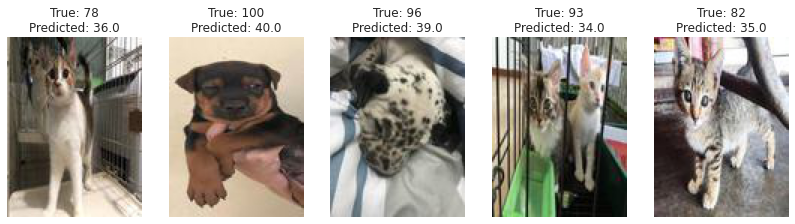

In [88]:
# View some of the images with large residuals 

large_residual_filter = residuals > 40
large_residual_Ids = pet_test_Ids[large_residual_filter]
large_residual_y_test = y_test[large_residual_filter]
large_residual_y_test_pred = y_test_pred[large_residual_filter]
print("Number of highly incorrect predictions: ", len(large_residual_Ids))

img_dir = "/content/petfinder/train/" # Enter Directory of all images  

# Build image list from the first 8 Ids
large_residual_ImageIds = []
for id in large_residual_Ids[:5]:
  image_name = img_dir + id + ".jpg"
  large_residual_ImageIds.append(image_name)

large_residual_y_test_pred_round = np.round(large_residual_y_test_pred, 0)
nrows, ncols = 1,5 #print first 8 images
fig, axs = plt.subplots(nrows, ncols, figsize=(14,8))
for i in range(ncols):
    image = Image.open(large_residual_ImageIds[i])
        
    axs[i].imshow(image)
    axs[i].set_title('True: ' + str(large_residual_y_test[i]) + '\nPredicted: ' + str(large_residual_y_test_pred_round[i]))
    axs[i].axis('off')

plt.show()

Number of highly correct predictions:  211


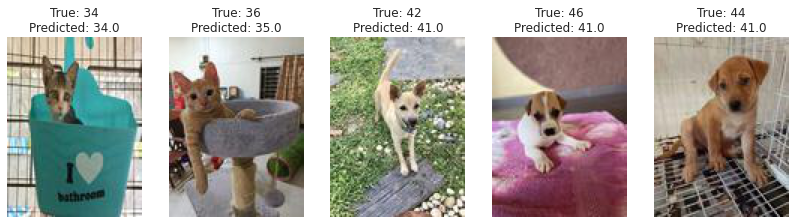

In [89]:
# View some of the images with large residuals 

small_residual_filter = residuals < 5
small_residual_Ids = pet_test_Ids[small_residual_filter]
small_residual_y_test = y_test[small_residual_filter]
small_residual_y_test_pred = y_test_pred[small_residual_filter]
print("Number of highly correct predictions: ", len(small_residual_Ids))

img_dir = "/content/petfinder/train/" # Enter Directory of all images  

# Build image list from the first 8 Ids
small_residual_ImageIds = []
for id in small_residual_Ids[:5]:
  image_name = img_dir + id + ".jpg"
  small_residual_ImageIds.append(image_name)

small_residual_y_test_pred_round = np.round(small_residual_y_test_pred, 0)
nrows, ncols = 1,5 #print first 8 images
fig, axs = plt.subplots(nrows, ncols, figsize=(14,8))
for i in range(ncols):
    image = Image.open(small_residual_ImageIds[i])
        
    axs[i].imshow(image)
    axs[i].set_title('True: ' + str(small_residual_y_test[i]) + '\nPredicted: ' + str(small_residual_y_test_pred_round[i]))
    axs[i].axis('off')

plt.show()

Among the images with very high residuals, it appears the model consistently predicts a lower score than the true score. There are fewer images with higher popularity scores and thus our model has trained on fewer of these examples. Based on the correlations observed and the coefficients of our model, the reason the model may have predicted lower scores from the above images are due to presence of a cat or blurriness. 

Among the images with very low residuals, it appears these images tend to have scores that are relatively on par with the average score (38). The model may be accurately predicting these images because their score is near the average.  

**Takeaways & Next Steps**


*   All 4 of our models performed relatively similarly with an RMSE in the range of 20-23. 
*   Linear regression provides interpretable insight into the characteristics of the most likeable pets in the data; the CNN is more opaque in translating to human understandable feedback about the characteristics of the image data that define likeability.
*   The CNN model in particular has many more hyperparameters that can be further tuned to enhance model performance. We explored image size, batch size, adding layers, changing the optimizer, augmentation, but only scratched the surface of the available techniques we could apply.
*   Moving forward, it would be helpful to understand what the relationship between popularity score and time to pet adoption is. In particular, if there is a wide range of popularity scores associated with the same general adoption time, this may impact the interpretation of our model’s RMSE. 
